# NLP notebook

In [113]:
import pandas as pd
import json
import os
from tqdm import tqdm
import numpy as np
import gzip
import shutil
import xml.etree.ElementTree as ET
import stanza
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string

### 1.3. Plot summaries extraction and cleaning

The corenlp_plot_summaries dataset is composed of gzipped folders, each containing a single xml file with matching name. Each folder-file corresponds to one movie, and the name is the movie ID.

We thus need to extract all zipped folder, and get the XML file. To do this, we will follow these steps:

1. Extract the gzipped folder using gzip package.
2. Move extracted files to a unique folder in clean_data.
3. Remove the empty folders after moving the files.

Same as above, this step only need to be performed one time.


In [ ]:
# Path to the zipped folders
NLP_DATA_PATH = "../corenlp_plot_summaries/"

# Path to the new data folder
NLP_SUMMARIES = "clean_data/NLP_summaries/"

# Create the new data folder if it doesn't exist
if not os.path.exists(NLP_SUMMARIES):
    os.makedirs(NLP_SUMMARIES)

# Iterate through each gzipped folder
for root, dirs, files in os.walk(NLP_DATA_PATH):
    for file in files:
        # Check if the file is a gzipped file
        if file.endswith(".gz"):
            # Path to the gzipped file contained in the folder
            gz_path = os.path.join(root, file)

            # Create a folder name based on the gzipped file name, removing the extension
            folder_name = os.path.splitext(file)[0]

            # Path to the destination folder
            destination_folder = os.path.join(NLP_SUMMARIES, folder_name)

            # Unzip the contents of the gzipped file to the destination folder
            with gzip.open(gz_path, "rb") as gz_file:
                with open(destination_folder, "wb") as out_file:
                    shutil.copyfileobj(gz_file, out_file)

# Move all XML files from the unzipped folders to the clean data folder
for root, dirs, files in os.walk(NLP_SUMMARIES):
    for file in files:
        # Check if the file is an XML file
        if file.endswith(".xml"):
            # Path to the XML file
            xml_path = os.path.join(root, file)

            # Move the XML file
            shutil.move(xml_path, os.path.join(NLP_SUMMARIES, file))

# Remove the empty folders left after moving the XML files
for root, dirs, files in os.walk(NLP_SUMMARIES, topdown=False):
    for folder in dirs:
        folder_path = os.path.join(root, folder)
        os.rmdir(folder_path)

Now, each XML file is stored in clean_data folder and can be read to analyze summary informations.


### 2.5 Exploration of plot summaries


In this part, we will first analyze the results of the CoreNLP pipeline already run on the summaries, stored in `clean_data/NLP_summaries`, and then apply sentiment analysis on the raw summaries

**CoreNLP results for one summary**

To begin, we will select one movie by specifying its ID and look at the data from the corresponding XML file.

To have the files, it is necessary to:

- download the supplementary dataset and put it at the level of the cloned repository
- run the section 1.3 to extract all files


In [2]:
# Path to the new data folder
NLP_SUMMARIES = "clean_data/NLP_summaries/"

# Select a movie
wiki_id = 23890098

# Path to the XML file
summary_test_file = NLP_SUMMARIES + str(wiki_id) + ".xml"
print(summary_test_file)

clean_data/NLP_summaries/23890098.xml


The corresponding summary can be found in the ```movies_summaries.csv``` file, using the index.

In [3]:
# Read the 2 csv
summaries_df = pd.read_csv("clean_data/movies_summaries.csv")
movies_df = pd.read_csv("clean_data/movies.csv")

# Add wiki_id from movies_df to summaries_df
summaries_df = summaries_df.rename(columns={"movie_id": "id"})
summaries_df = summaries_df.merge(movies_df[["id", "wiki_id"]], on="id")
display(summaries_df.head())

# Access the summary where wiki_id = movie_id
summary_test = summaries_df.loc[summaries_df['wiki_id'] == wiki_id]['summary'].values[0]
print(summary_test)

,id,summary,wiki_id
0,/m/076w2lb,"Shlykov, a hard-working taxi driver and Lyosha...",23890098
1,/m/0gkz15s,The nation of Panem consists of a wealthy Capi...,31186339
2,/m/051zjwb,Poovalli Induchoodan is sentenced for six yea...,20663735
3,/m/06xtz3,"The Lemon Drop Kid , a New York City swindler,...",2231378
4,/m/02tqm5,Seventh-day Adventist Church pastor Michael Ch...,595909


Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.


Each `<token>` element represents a word from a sentence, identified by a unique `id`. Inside each `<token>` element, there are several child elements that provide more information about the token:

- `<word>`: The actual word in the text.
- `<lemma>`: The base or dictionary form of the word.
- `<CharacterOffsetBegin>` and `<CharacterOffsetEnd>`: The start and end positions of the word in the original text.
- `<POS>`: The part-of-speech tag for the word. POS tagging is the task of labeling the words in a sentence with their appropriate part of speech (noun, verb, adjective, etc.).
- `<NER>`: Named Entity Recognition tag. NER is a subtask of information extraction that seeks to locate and classify named entities in text into predefined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

The `<sentence>` element contains a set of these tokens, representing a sentence in the text. The `id` attribute of the `<sentence>` element indicates the order of the sentence in the document.


In [4]:
#FIXME: Correct the extraction --> iterate over sentences!! See function below

# Parse the XML file and get the root element
tree = ET.parse(summary_test_file)
root = tree.getroot()

# Create an empty dict to store data
tokens_dict = {}

# Iterate over all 'token' elements in the document
for token in root.iter("token"):
    # Extract data from the child elements of 'token'
    word = token.find("word").text
    lemma = token.find("lemma").text
    pos = token.find("POS").text
    ner = token.find("NER").text

    # Store in dict
    token_id = token.attrib["id"]
    tokens_dict[token_id] = {
        "word": word,
        "lemma": lemma,
        "POS": pos,
        "NER": ner,
    }

# Print the dict
print(tokens_dict)

{'1': {'word': 'Shlykov', 'lemma': 'Shlykov', 'POS': 'NNP', 'NER': 'PERSON'}, '2': {'word': ',', 'lemma': ',', 'POS': ',', 'NER': 'O'}, '3': {'word': 'a', 'lemma': 'a', 'POS': 'DT', 'NER': 'O'}, '4': {'word': 'hard-working', 'lemma': 'hard-working', 'POS': 'JJ', 'NER': 'O'}, '5': {'word': 'taxi', 'lemma': 'taxi', 'POS': 'NN', 'NER': 'O'}, '6': {'word': 'driver', 'lemma': 'driver', 'POS': 'NN', 'NER': 'O'}, '7': {'word': 'and', 'lemma': 'and', 'POS': 'CC', 'NER': 'O'}, '8': {'word': 'Lyosha', 'lemma': 'Lyosha', 'POS': 'NNP', 'NER': 'PERSON'}, '9': {'word': ',', 'lemma': ',', 'POS': ',', 'NER': 'O'}, '10': {'word': 'a', 'lemma': 'a', 'POS': 'DT', 'NER': 'O'}, '11': {'word': 'saxophonist', 'lemma': 'saxophonist', 'POS': 'NN', 'NER': 'O'}, '12': {'word': ',', 'lemma': ',', 'POS': ',', 'NER': 'O'}, '13': {'word': 'develop', 'lemma': 'develop', 'POS': 'VB', 'NER': 'O'}, '14': {'word': 'a', 'lemma': 'a', 'POS': 'DT', 'NER': 'O'}, '15': {'word': 'bizarre', 'lemma': 'bizarre', 'POS': 'JJ', 'NER

Each sentence also has dependency informations between tokens:

- `<basic-dependencies>`: These represent grammatical relationships between words in a sentence. For example, the dependencies between noun and verb.

- `<collapsed-dependencies>`: These are a simplified form of dependencies where certain types of indirect dependencies are collapsed into direct dependencies for easier processing.


In [ ]:
# Create an empty dict to store data
dep_dict = {}

# Extract and print dependencies
for i, dep in enumerate(root.iter("dep")):
    # Extract data
    dep_type = dep.attrib["type"]
    governor = dep.find("governor").text
    dependent = dep.find("dependent").text

    # Store in dict
    dep_dict[i] = {"type": dep_type, "governor": governor, "dependent": dependent}


print(dep_dict)

{0: {'type': 'prep', 'governor': 'is', 'dependent': 'After'}, 1: {'type': 'auxpass', 'governor': 'pulled', 'dependent': 'being'}, 2: {'type': 'pcomp', 'governor': 'After', 'dependent': 'pulled'}, 3: {'type': 'prep', 'governor': 'pulled', 'dependent': 'through'}, 4: {'type': 'det', 'governor': 'portal', 'dependent': 'a'}, 5: {'type': 'nn', 'governor': 'portal', 'dependent': 'time'}, 6: {'type': 'pobj', 'governor': 'through', 'dependent': 'portal'}, 7: {'type': 'nn', 'governor': 'lands', 'dependent': 'Ash'}, 8: {'type': 'nn', 'governor': 'lands', 'dependent': 'Williams'}, 9: {'type': 'nsubj', 'governor': 'is', 'dependent': 'lands'}, 10: {'type': 'prep', 'governor': 'lands', 'dependent': 'in'}, 11: {'type': 'num', 'governor': 'AD', 'dependent': '1300'}, 12: {'type': 'pobj', 'governor': 'in', 'dependent': 'AD'}, 13: {'type': 'advmod', 'governor': 'captured', 'dependent': 'where'}, 14: {'type': 'nsubjpass', 'governor': 'captured', 'dependent': 'he'}, 15: {'type': 'auxpass', 'governor': 'cap

Finaly, dependencies between different sentences can be analyzed:

- `<coreferences>`: These represent instances where multiple expressions in a text refer to the same entity.

In the XML, each `<coreference>` element represents a group of mentions that all refer to the same entity in the text. Each `<mention>` element within a `<coreference>` represents a specific instance where that entity is mentioned in the text.
The `<mention representative="true">` is the primary mention in the text that other mentions refer back to.

The `<sentence>` tag within a `<mention>` indicates the sentence number where the mention occurs. The `<start>` and `<end>` tags indicate the position of the start and end of the mention within that sentence. The `<head>` tag indicates the head word of the mention.

To know what a coreference corresponds to in the actual text, we would need to find the sentences and word positions indicated by the `<sentence>`, `<start>`, and `<end>` tags in the text itself.


In [ ]:
# Create an empty dict to store data
coref_dict = {}

# Extract and print coreferences
for i, coref in enumerate(root.iter("coreference")):
    coref_dict[i] = {}
    for j, mention in enumerate(coref.iter("mention")):
        # Extract data
        sentence = mention.find("sentence").text
        start = mention.find("start").text
        end = mention.find("end").text

        # Store in dict
        coref_dict[i][j] = {"sentence": sentence, "start": start, "end": end}

print(coref_dict)

{0: {0: {'sentence': '1', 'start': '23', 'end': '26'}, 1: {'sentence': '3', 'start': '18', 'end': '20'}, 2: {'sentence': '2', 'start': '6', 'end': '15'}, 3: {'sentence': '1', 'start': '36', 'end': '38'}, 4: {'sentence': '2', 'start': '6', 'end': '9'}, 5: {'sentence': '2', 'start': '8', 'end': '9'}, 6: {'sentence': '4', 'start': '3', 'end': '4'}, 7: {'sentence': '4', 'start': '5', 'end': '6'}, 8: {'sentence': '5', 'start': '1', 'end': '2'}, 9: {'sentence': '21', 'start': '21', 'end': '23'}, 10: {'sentence': '16', 'start': '17', 'end': '19'}, 11: {'sentence': '21', 'start': '34', 'end': '35'}, 12: {'sentence': '15', 'start': '14', 'end': '23'}, 13: {'sentence': '15', 'start': '14', 'end': '16'}, 14: {'sentence': '1', 'start': '13', 'end': '42'}, 15: {'sentence': '1', 'start': '13', 'end': '15'}, 16: {'sentence': '1', 'start': '33', 'end': '42'}, 17: {'sentence': '1', 'start': '17', 'end': '18'}, 18: {'sentence': '1', 'start': '30', 'end': '31'}, 19: {'sentence': '2', 'start': '1', 'end':

We finally get for each summary:

- A `token dictionnary` containing the word, lemma, POS and NER of each tokens (words) of the summary.
- A `dependency dictionnary` containing each gramatical dependencies found in the summary along with the dependency type.
- A `coreference dictionnary` referencing for each coreference (entity refered to) all the group of words related to it in a specific sentence.

To be used for all summaries, we built a function to extract those 3 dictionnaries from the XML file.


In [5]:
def extract_NLP_data(xml_file):
    """
    Extracts the tokens, dependencies and coreferences from an XML file
    and returns them in a dict.

    Args
        xml_file (str): Path to the XML file.

    Returns
        tokens_dict (dict): Dict containing the tokens.
        dep_dict (dict): Dict containing the dependencies.
        coref_dict (dict): Dict containing the coreferences.
    """
    # Parse the XML file and get the root element
    tree = ET.parse(xml_file)
    root = tree.getroot()

    
    # Create an empty dict to store data
    tokens_dict = {}
    dep_dict = {}

    # Iterate over sequences
    for i,sentence in enumerate(root.iter("sentence")):
        #---------- Extract tokens ----------#
        tokens_dict[i+1] = {}
        for token in sentence.iter("token"):
            # Extract data from the child elements of 'token'
            word = token.find("word").text
            lemma = token.find("lemma").text
            pos = token.find("POS").text
            ner = token.find("NER").text

            # Store in dict
            token_id = token.attrib["id"]
            tokens_dict[i+1][token_id] = {
                "word": word,
                "lemma": lemma,
                "POS": pos,
                "NER": ner,
            }
        
        #---------- Extract dependencies ----------#
        dep_dict[i+1] = {}
        for d, dep in enumerate(sentence.iter("dep")):
            # Extract data
            dep_type = dep.attrib["type"]
            governor = dep.find("governor").text
            dependent = dep.find("dependent").text

            # Store in dict
            dep_dict[i+1][d] = {
                "type": dep_type, 
                "governor": governor, 
                "dependent": dependent,
            }
   

    #---------- Extract coreferences ----------#
    # Create an empty dict to store data
    coref_dict = {}

    # Extract coreferences
    for i, coref in enumerate(root.iter("coreference")):
        coref_dict[i] = {}
        for j, mention in enumerate(coref.iter("mention")):
            # Extract data
            sentence = mention.find("sentence").text
            start = mention.find("start").text
            end = mention.find("end").text

            # Store in dict
            coref_dict[i][j] = {"sentence": sentence, "start": start, "end": end}

    return tokens_dict, dep_dict, coref_dict

In [6]:
tokens_dict, dep_dict, coref_dict = extract_NLP_data(summary_test_file)

print('Token dict:', tokens_dict)
print('Dep dict:', dep_dict)
print('Coref dict:', coref_dict)

Token dict: {1: {'1': {'word': 'Shlykov', 'lemma': 'Shlykov', 'POS': 'NNP', 'NER': 'PERSON'}, '2': {'word': ',', 'lemma': ',', 'POS': ',', 'NER': 'O'}, '3': {'word': 'a', 'lemma': 'a', 'POS': 'DT', 'NER': 'O'}, '4': {'word': 'hard-working', 'lemma': 'hard-working', 'POS': 'JJ', 'NER': 'O'}, '5': {'word': 'taxi', 'lemma': 'taxi', 'POS': 'NN', 'NER': 'O'}, '6': {'word': 'driver', 'lemma': 'driver', 'POS': 'NN', 'NER': 'O'}, '7': {'word': 'and', 'lemma': 'and', 'POS': 'CC', 'NER': 'O'}, '8': {'word': 'Lyosha', 'lemma': 'Lyosha', 'POS': 'NNP', 'NER': 'PERSON'}, '9': {'word': ',', 'lemma': ',', 'POS': ',', 'NER': 'O'}, '10': {'word': 'a', 'lemma': 'a', 'POS': 'DT', 'NER': 'O'}, '11': {'word': 'saxophonist', 'lemma': 'saxophonist', 'POS': 'NN', 'NER': 'O'}, '12': {'word': ',', 'lemma': ',', 'POS': ',', 'NER': 'O'}, '13': {'word': 'develop', 'lemma': 'develop', 'POS': 'VB', 'NER': 'O'}, '14': {'word': 'a', 'lemma': 'a', 'POS': 'DT', 'NER': 'O'}, '15': {'word': 'bizarre', 'lemma': 'bizarre', '

- Token_dict: each sentence contains a dict of tokens
- Dep_diict: contains a dict of dependencies
- Coref_dict: each coref contains a dict of related refs (token numbers and their sentence)

**Sentiment analysis for a few summaries**

In this part, we will apply sentiment analysis on the sentences of one summary. To do this, we use the stanza package


First, we will load the raw summaries from the cleaned data.


In [6]:
# Define data path
DATA_PATH = "clean_data/"

# Load summaries
summaries_df = pd.read_csv(DATA_PATH + "movies_summaries.csv")
display(summaries_df)

,movie_id,summary
0,/m/076w2lb,"Shlykov, a hard-working taxi driver and Lyosha..."
1,/m/0gkz15s,The nation of Panem consists of a wealthy Capi...
2,/m/051zjwb,Poovalli Induchoodan is sentenced for six yea...
3,/m/06xtz3,"The Lemon Drop Kid , a New York City swindler,..."
4,/m/02tqm5,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42199,/m/0j3dcl6,"The story is about Reema , a young Muslim scho..."
42200,/m/045pct,"In 1928 Hollywood, director Leo Andreyev look..."
42201,/m/0j6777g,American Luthier focuses on Randy Parsons’ tra...
42202,/m/04f7jfs,"Abdur Rehman Khan , a middle-aged dry fruit se..."


Then, we will import the stanza model for sentiment analysis.


In [31]:
# Download english model
stanza.download("en")

# initialize English neural pipeline
nlp = stanza.Pipeline(lang="en")

2023-12-16 12:14:13 INFO: Downloading default packages for language: en (English) ...
2023-12-16 12:14:14 INFO: File exists: C:\Users\chlea\stanza_resources\en\default.zip
2023-12-16 12:14:18 INFO: Finished downloading models and saved to C:\Users\chlea\stanza_resources.
2023-12-16 12:14:18 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-12-16 12:14:20 INFO: Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| pos          | combined_charlm     |
| lemma        | combined_nocharlm   |
| constituency | ptb3-revised_charlm |
| depparse     | combined_charlm     |
| sentiment    | sstplus             |
| ner          | ontonotes_charlm    |

2023-12-16 12:14:20 INFO: Using device: cpu
2023-12-16 12:14:20 INFO: Loading: tokenize
2023-12-16 12:14:20 INFO: Loading: pos
2023-12-16 12:14:20 INFO: Loading: lemma
2023-12-16 12:14:20 INFO: Loading: constituency
2023-12-16 12:14:20 INFO: Loading: depparse
2023-12-16 12:14:21 INFO: Loading: sentiment
2023-12-16 12:14:21 INFO: Loading: ner
2023-12-16 12:14:21 INFO: Done loading processors!


Now, we need to convert the summaries to stanza documents to be able to use the package:


In [8]:
# Convert the summaries column of df into a list
summaries = summaries_df["summary"].tolist()

# Select a subset of summaries for testing
summaries_test = summaries[0:4]

# Wrap each document with a stanza.Document object
summaries_list = [stanza.Document([], text=p) for p in summaries_test]

We will now iterate on the test list to get the sentiment scores. The sentiment is expressed by a simple classification:

- 1 = Negative sentiment
- 2 = Neutral sentiment
- 3 = Positive sentiment

Each sentence of the summaries is associated with such class, resulting in a list of sentiment scores for each summary.

We iterate on a loop instead of passing the list directly to the function to avoid running out of RAM on such large data.


In [9]:
for i, summary in enumerate(summaries_list):
    print("---------")
    print(f"Summary {i+1}:")

    # Run nlp pipeline
    doc = nlp(summary)

    # Print sentences sentiments
    sentiment_scores = []
    for i, sentence in enumerate(doc.sentences):
        sentiment_scores.append(sentence.sentiment)
    print("Sentiment scores: ", sentiment_scores)

---------
Summary 1:
Sentiment scores:  [1]
---------
Summary 2:
Sentiment scores:  [1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
---------
Summary 3:
Sentiment scores:  [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
---------
Summary 4:
Sentiment scores:  [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


We thus get for each summary a list of sentiment scores corresponding to each sentence. In the following steps, we will run these analysis on the entire dataset and continue on this track to include NLP to complete the previous analyses.


**Putting all together**

Now that we have seen the way we can analyze plot summaries, we will proceed to include plot summaries informations into our previous analyses.

First, we will define a function that we can use to do the analysis for a set of movies, for example to be used for the different regions. This functions asks for a vocabulary list of words to manage, for example the lexical of female.

In [51]:
vocabulary = ['female', 'woman', 'girl', 'lady', 'princess', 'queen', 'she', 'She', 'her', 'her', 'mother', 'mom', 'mommy', 'wife', 'sister', 'daughter']
wiki_ids = summaries_df["wiki_id"].tolist()[:10]
data_folder = NLP_SUMMARIES

In [68]:
def analyze_NLP_data(wiki_ids,data_folder,vocabulary,print_results=False):
    """
    Extracts the tokens, dependencies and coreferences from an XML file
    and returns them in a dict.

    Args
        wiki_ids (list): List of wiki_ids.
        data_folder (str): Path to the folder containing the XML files.
        vocabulary (list): List of words to search for in the XML files.

    Returns
        vocabulary_dict_all (list): List of dicts containing the vocabulary.
        sentiment_scores_all (list): List of lists containing the sentiment scores.
        correferences_all (list): List of lists containing the correferences.
    """
    # Create empty lists to store data
    vocabulary_dict_all = []
    tokens_all = []
    sentiment_scores_all = []
    correferences_all = []

    # Iterate over all the movies
    for wiki_id in tqdm(wiki_ids):
        #-------- Extract NLP data --------#
        # Path to the XML file
        summary_file = data_folder + str(wiki_id) + ".xml"

        # Extract the tokens, dependencies and coreferences
        tokens_dict, dep_dict, coref_dict = extract_NLP_data(summary_file)

        #-------- Load summary for the corresponding movie--------#
        summary_text = summaries_df.loc[summaries_df['wiki_id'] == wiki_id]['summary'].values[0]
        sentences_text = summary_text.split(".")
        for i,sentence in enumerate(sentences_text):
            # separate words
            words = sentence.split(" ")
            sentences_text[i] = words
        
        #-------- Extract NLP data --------#
        # Path to the XML file
        summary_file = data_folder + str(wiki_id) + ".xml"

        # Extract the tokens, dependencies and coreferences
        tokens_dict, dep_dict, coref_dict = extract_NLP_data(summary_file)

        #-------- Search for vocabulary in tokens --------#
        # Create an empty dict to store data
        vocabulary_dict = {}
        tokens = []

        # Iterate over all the sentences stored in tokens_dict
        for sentence_id, sentence_tokens in tokens_dict.items():
            # Iterate over all the tokens
            for token_id, token in sentence_tokens.items():
                # Check if the token is in the vocabulary
                if token["lemma"] in vocabulary:
                    # Store in dict
                    vocabulary_dict[sentence_id] = {}
                    vocabulary_dict[sentence_id][token_id] = {
                        #'sentence_id': sentence_id, 
                        'token_id': token_id, 
                        'token': token,
                    }
                    # Store the token
                    tokens.append(token["lemma"])
        
        # Add to the list if not empty
        if vocabulary_dict != {}:
            vocabulary_dict_all.append(vocabulary_dict)
            tokens_all.append(tokens)

        #-------- Sentiment analysis on sentences where vocabulary was detected  --------#
        # Wrap each document with a stanza.Document object
        summary_doc = stanza.Document([], text=summary_text)

        # Run nlp pipeline
        summary_doc = nlp(summary_doc)

        # Get the sentences to analyze
        sentences_ids = list(vocabulary_dict.keys())

        # Analyze the sentences
        sentiment_scores = []
        for i, sentence in enumerate(summary_doc.sentences):
            #print(sentence)
            if i+1 in sentences_ids:
                sentiment_scores.append(sentence.sentiment)

        # Store the sentiment scores
        if sentiment_scores != []:
            sentiment_scores_all.append(sentiment_scores)

        #-------- Search for detected vocabulary in dependences and coreferences --------#
        # Iterate over coreferences dict to find the sentences where the vocabulary was detected
        all_words = []
        for coref_id, corefs in coref_dict.items():
            # extract coref representative word for each coreferences group
            for coref_item_id, coref_item in corefs.items():
                # Get the first coreference
                coref_representative = [int(coref_item["sentence"]), int(coref_item["start"]), int(coref_item["end"])]
                word_representatives = sentences_text[coref_representative[0]-1][coref_representative[1]:coref_representative[2]]

                # check is the coref representative word is in the vocabulary
                for word_representative in word_representatives:
                    if word_representative in vocabulary:
                        # add the word to the list
                        all_words.append(word_representative)

                        # Get the other coreferences
                        for coref_item_id_2, coref_item_2 in corefs.items():
                            if coref_item_id_2!=coref_item_id:
                                coref = [int(coref_item_2["sentence"]), int(coref_item_2["start"]), int(coref_item_2["end"])]
                                word = sentences_text[coref[0]-1][coref[1]-1:coref[2]-1]
                                all_words.append(word)
                        
            
        # Store the coreferences
        correferences_all.append(all_words)

        if print_results:
            print("----- Movie: ", wiki_id, "------")
            print("Summary: ", summary_text)
            print("Sentences: ", sentences_text)
            print("Vocabulary: ", vocabulary_dict)
            print("Sentiment scores: ", sentiment_scores)
            print("Correferences: ", all_words)

    # remove empty lists and words
    correferences_all = [x for correferences in correferences_all for x in correferences if x != [] and x != '' and x != [""]]

    # Print 
    if print_results:
        print("--------- Global results ---------")
        print("Sentiment scores: ", sentiment_scores_all)
        print("Correferences: ", correferences_all)
        print("Vocabulary: ", vocabulary_dict_all)
        print("Tokens: ", tokens_all)

    return vocabulary_dict_all, tokens_all, sentiment_scores_all, correferences_all


Now, we can use this function to get the relevant informations from the set of movies.

In [69]:
vocabulary_dict_all, tokens_all, sentiment_scores_all, correferences_all = analyze_NLP_data(wiki_ids,data_folder,vocabulary,print_results=True)

 10%|█         | 1/10 [00:01<00:17,  1.90s/it]

----- Movie:  23890098 ------
Summary:  Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.
Sentences:  [['Shlykov,', 'a', 'hard-working', 'taxi', 'driver', 'and', 'Lyosha,', 'a', 'saxophonist,', 'develop', 'a', 'bizarre', 'love-hate', 'relationship,', 'and', 'despite', 'their', 'prejudices,', 'realize', 'they', "aren't", 'so', 'different', 'after', 'all'], ['']]
Vocabulary:  {}
Sentiment scores:  []
Correferences:  []


 20%|██        | 2/10 [00:13<01:01,  7.65s/it]

----- Movie:  31186339 ------
Summary:  The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker's son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy. He warns them about the "Career" tributes who train intensively at special academies and almost always win. During a TV interview with Caesar Flickerman, Peeta unexpectedly reveals his love for Katniss. She is outraged, believing it to be a ploy to 

 30%|███       | 3/10 [00:22<00:57,  8.22s/it]

----- Movie:  20663735 ------
Summary:  Poovalli Induchoodan  is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon  was framed in the case by Manapally Madhavan Nambiar  and his crony DYSP Sankaranarayanan  to take revenge on idealist judge Menon who had earlier given jail sentence to Manapally in a corruption case. Induchoodan, who had achieved top rank in Indian Civil Service loses the post and Manapally Sudheeran ([[Saikumar  enters the list of civil service trainees. We learn in flashback that it was Ramakrishnan  the son of Moopil Nair , who had actually killed his classmate. Six years passes by and Manapally Madhavan Nambiar, now a former state minister, is dead and Induchoodan, who is all rage at the gross injustice meted out to him - thus destroying his promising life, is released from prison. Induchoodan thwarts Manapally Pavithran  from performing the funeral rituals of Nambiar at Bharathapuzha. M

 40%|████      | 4/10 [00:34<00:57,  9.61s/it]

----- Movie:  2231378 ------
Summary:  The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfortunately for the Kid, the woman "belongs" to notorious gangster Moose Moran , as does the money. The Kid's choice finishes dead last and a furious Moran demands the Kid provide him with $10,000  by Christmas Eve, or the Kid "won't make it to New Year's." The Kid decides to return to New York to try to come up with the money. He first tries his on-again, off-again girlfriend Brainy Baxter . However, when talk of long-term commitment arises, the Kid quickly makes an escape. He next visits local crime boss "Oxford" Charley , with whom he has had past dealings. This falls through as Charley is in serious tax trouble and does not particularly care for the Kid a

 50%|█████     | 5/10 [00:42<00:46,  9.23s/it]

----- Movie:  595909 ------
Summary:  Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy returns to the tent to check on Azaria and is certain she sees a dingo with something in its mouth running off as she approaches. When she discovers the infant is missing, everyone joins forces to search for her, without success. It is assumed what Lindy saw was the animal carrying off the child, and a subsequent inquest rules her account of events is true. The tide of public opinion soon turns against the Chamberlains. For many, Lindy seems too stoic, too cold-hearted, and too accepting of the disaster that has befallen her. Gossip about her begins to swell and soon is accepted as statements of fact. The couple's beliefs are not widely practised in the count

 60%|██████    | 6/10 [00:48<00:32,  8.04s/it]

----- Movie:  5272176 ------
Summary:  The president is on his way to give a speech. While he is traveling there a man shows up with a camera. A reporter tries to ask a member of the secret service a question. When the president enters he is shot by the man with the camera. The president's main bodyguard, Alex Thomas , is grazed by the bullet that hits the president. The shooter is gunned down by Alex and other secret service agents. The president dies at the hospital. Kate Crawford , an investigative journalist, starts asking questions about the assassination. Anyone she questions is killed. She goes to Alex Thomas's house to tell him what is happening. As they head to his boat, Thomas sees some men hiding in the bushes. He throws Kate into the water and dives in. Thomas jumps out of the water to kill two of the hitmen while a third hitman drives off to inform his boss what happened. They are able to link the hitmen to a man called Jack Baldwin . Agent Thomas and other Secret Service 

 70%|███████   | 7/10 [01:00<00:27,  9.29s/it]

----- Movie:  1952976 ------
Summary:  {{plot}} The film opens in 1974, as a young girl, Dahlia, stands outside after school in the rain, waiting for her mother. Flash forward to 2005, we see a grown-up Dahlia  in the midst of a bitter mediation with ex-husband, Kyle , over custody of their daughter, Cecilia . Kyle wants Cecilia to live closer to his apartment in Jersey City, but Dahlia wants to move to Roosevelt Island, where she has found a good school. Kyle threatens to sue for full custody because he feels the distance is too great. He also claims that Dahlia is "mentally unstable." Dahlia and Cecilia see an apartment in a complex on Roosevelt Island, which is just a few blocks from Cecilia's new school. The superintendent of the dilapidated building is Mr. Veeck . The manager is Mr. Murray . During the tour, Cecilia sneaks to the roof where she finds a Hello Kitty backpack near a large water tank. They leave the bag with Veeck, and Murray promises Cecilia that she can have it if n

 80%|████████  | 8/10 [01:10<00:19,  9.53s/it]

----- Movie:  24225279 ------
Summary:  The story begins with Hannah, a young Jewish teen, as she is completing her senior year of high school. Her small neighborhood in Brooklyn is falling apart and SING! is one of the only traditions keeping the neighborhood alive. Newly arrived teacher, Miss Lombardo grew up in the neighborhood but returned to be their Sing Leader. One cold Christmas night, Miss Lombardo is leaving a neighborhood party when a young man hails her a cab, then attempts to mug her. In self defense, she bites his hand to release his grip and he screams in pain and terror, quickly making an exit. The cab driver jokes about not starting the meter yet. On the first day of school, Miss Lombardo runs into difficulty when her students are uninterested and misbehaved. One such student was named Dominic who gets scolded for bringing stolen watches to school grounds and putting his feet up on the desk. On the day of Sing Leader elections, Miss Lombardo recognizes Dominic as her m

 90%|█████████ | 9/10 [01:22<00:10, 10.46s/it]

----- Movie:  2462689 ------
Summary:  Infuriated at being told to write one final column after being laid off from her newspaper job, Ann Mitchell  prints a letter from a fictional unemployed "John Doe" threatening suicide on Christmas Eve in protest of society's ills. When the note causes a sensation and the paper's competition suspects a fraud and starts to investigate, the newspaper editor rehires Mitchell who comes up with a scheme of hiding the fictional nature of "John Doe" while exploiting the sensation caused by the fake letter to boost the newspaper's sales, for which she demands a bonus equal to 8 months' pay. After reviewing a number of derelicts who have shown up at the paper claiming to have penned the original suicide letter, Mitchell and editor Henry Connell  hire John Willoughby , a former baseball player and tramp who is in need of money to repair his injured arm, to play John Doe. Mitchell now starts to pen an article series in Doe's name, elaborating on the letter's

100%|██████████| 10/10 [01:26<00:00,  8.67s/it]

----- Movie:  20532852 ------
Summary:  A line of people  drool at the window of the shop of market butcher Buzz Buzzard. A short series of gags ensues about how Buzz dishonestly  "jacks" up all his prices. Since Woody is broke as usual, he sneaks in and gets thrown out by Buzz. On the way out, Woody collides with a bottle of invisible ink and turns partially invisible. Buzz can only see parts of Woody's body, and, in a somewhat gruesome scene, thinks that he's been dismembered, so he sweeps him into a trap door to get rid of him. When Woody awakes, he realizes what is happening, and he douses himself with the rest of the ink in order to pose as a ghost.
Sentences:  [['A', 'line', 'of', 'people', '', 'drool', 'at', 'the', 'window', 'of', 'the', 'shop', 'of', 'market', 'butcher', 'Buzz', 'Buzzard'], ['', 'A', 'short', 'series', 'of', 'gags', 'ensues', 'about', 'how', 'Buzz', 'dishonestly', '', '"jacks"', 'up', 'all', 'his', 'prices'], ['', 'Since', 'Woody', 'is', 'broke', 'as', 'usual,'

It's not time to analyze the results of this extraction using different visualization techniques.

In [114]:
# Download and define set of stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(set(string.punctuation))

# Flatten correferences_all and remove stopwords
correferences_all_flat = [item for sublist in correferences_all for item in sublist]
correferences_all_flat = [word for word in correferences_all_flat if word not in stop_words]
correferences_all_flat = [word for word in correferences_all_flat if len(word)>1]

# Flatten tokens_all
tokens_all_flat = [item for sublist in tokens_all for item in sublist]

# Flatten sentiment_scores_all
sentiment_scores_all_flat = [item for sublist in sentiment_scores_all for item in sublist]

# Convert to a DataFrame
vocabulary_df = pd.DataFrame(tokens_all_flat)
sentiment_scores_df = pd.DataFrame.from_dict(sentiment_scores_all_flat)
correferences_df = pd.DataFrame(correferences_all_flat)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chlea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [119]:
# Get the top 10 tokens
token_counts = vocabulary_df[0].value_counts()
top_10_tokens = token_counts.head(10)

# Convert Series to DataFrame for seaborn
top_10_tokens_df = top_10_tokens.reset_index()
top_10_tokens_df.columns = ['Token', 'Count']

# Get the sentiment scores counts
sentiment_counts = sentiment_scores_df[0].value_counts()

# Convert Series to DataFrame for seaborn
sentiment_df = sentiment_counts.reset_index()
sentiment_df.columns = ['Sentiment', 'Count']

# Get the top 10 correferences
correference_counts = correferences_df[0].value_counts()
top_10_correferences = correference_counts.head(10)

# Convert Series to DataFrame for seaborn
top_10_correferences_df = top_10_correferences.reset_index()
top_10_correferences_df.columns = ['Correference', 'Count']

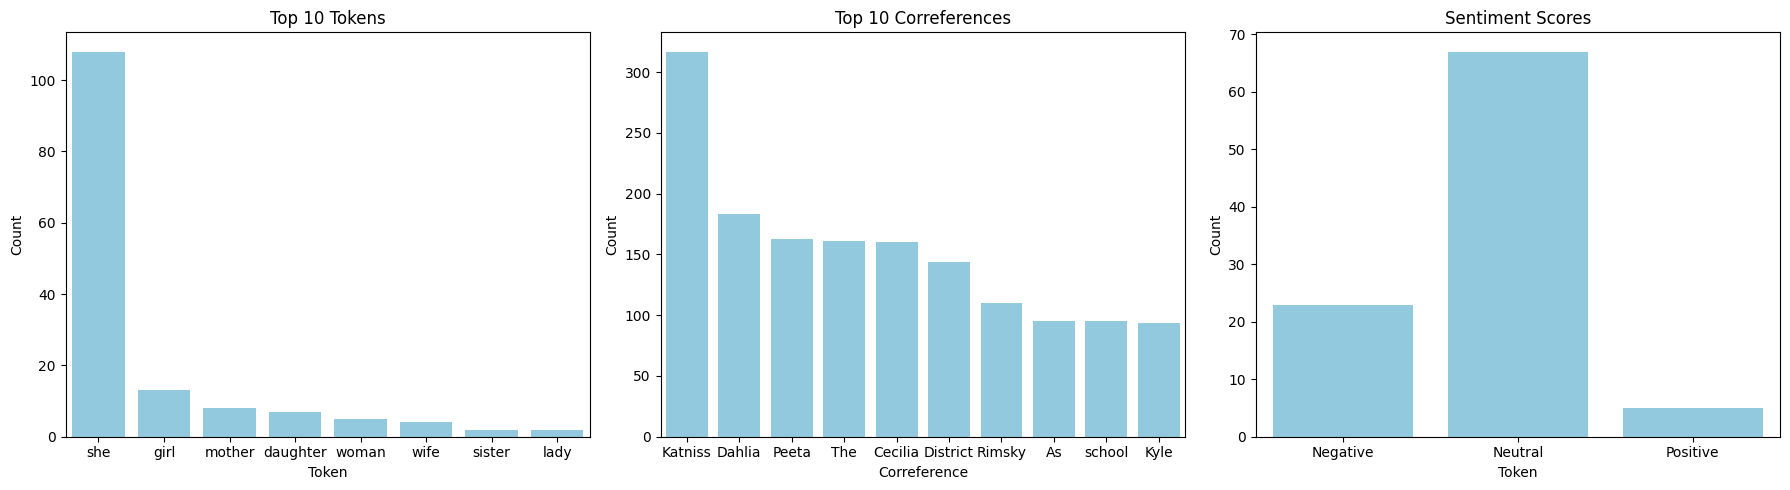

In [124]:
# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot the counts of the top 10 tokens
sns.barplot(x='Token', y='Count', data=top_10_tokens_df, color='skyblue', ax=axes[0])
axes[0].set_title('Top 10 Tokens')
axes[0].set_xlabel('Token')
axes[0].set_ylabel('Count')

# Plot the counts of the top 10 correferences
sns.barplot(x='Correference', y='Count', data=top_10_correferences_df, color='skyblue', ax=axes[1])
axes[1].set_title('Top 10 Correferences')
axes[1].set_xlabel('Correference')
axes[1].set_ylabel('Count')

# Plot the counts of unique sentiment scores
sns.barplot(x='Sentiment', y='Count', data=sentiment_df, color='skyblue')
axes[2].set_title('Sentiment Scores')
axes[2].set_xlabel('Token')
axes[2].set_ylabel('Count')
axes[2].set_xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# FIXME: pas d'influence si majuscule ou minuscule